In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.patches as mpatches
import seaborn as sns
import wordcloud

from gensim import corpora, models
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer 
from nltk.stem import WordNetLemmatizer


/Users/meggan/Library/Python/3.8/lib/python/site-packages/nltk/decorators.py:67: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  signature = inspect.formatargspec(
/Users/meggan/Library/Python/3.8/lib/python/site-packages/nltk/lm/counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Sequence, defaultdict


In [2]:
# BLOG ARTICLES DATA

df_filed = pd.read_csv('./data/files_all_articles.csv') #Fathom 
df_A_theblondeabroad = pd.read_csv('./data/articles_theblondeabroad.csv')
df_A_amateurtraveler = pd.read_csv('./data/articles_amateurtraveler.csv')
df_A_bemytravelmuse = pd.read_csv('./data/articles_bemytravelmuse.csv')
df_A_nerdnomads = pd.read_csv('./data/articles_nerdnomads.csv')
df_A_ordinarytraveler = pd.read_csv('./data/articles_ordinarytraveler.csv')

# Fathom data was saved without ignoring the index ...
df_filed.drop(columns=['Unnamed: 0'], inplace=True)

# Combined Web-Scraped Blog Articles
df_A_ALL_filed = [df_filed, df_A_theblondeabroad, df_A_amateurtraveler,
          df_A_bemytravelmuse, df_A_nerdnomads, df_A_ordinarytraveler]

df_blogs = pd.concat(df_A_ALL_filed, ignore_index=True)
df_blogs['all_words'] = df_blogs['title'] + df_blogs['text']


# SUBREDDIT POSTS DATA

df_reddit = pd.read_csv('./data/subreddits.csv')

print('# of blog articles:', df_blogs.shape[0])
print('# of subreddit posts:', df_reddit.shape[0])
print()
print('# of distinct countries in the blog articles:',len(df_blogs['country'].value_counts()))
print('# of distinct countries in the subreddit posts:',len(df_reddit['country'].value_counts()))

# of blog articles: 2498
# of subreddit posts: 31568

# of distinct countries in the blog articles: 129
# of distinct countries in the subreddit posts: 178


In [3]:
df_blogs['country'].value_counts()[:10]

Italy        167
Japan        106
France        98
Mexico        98
Thailand      86
Indonesia     81
Spain         69
Iceland       64
China         63
India         56
Name: country, dtype: int64

In [4]:
df_reddit['country'].value_counts()[:10]

India        1084
Germany      1074
Vietnam      1026
Australia     993
Canada        951
Thailand      926
France        873
Italy         835
Japan         800
Spain         779
Name: country, dtype: int64

In [5]:
# Countries with only one article filed across all blogs
print('Only one Blog Article:',df_blogs['country'].value_counts()[df_blogs['country'].value_counts()==1].index)
print()
print('Only one Subreddit Post:',df_reddit['country'].value_counts()[df_reddit['country'].value_counts()==1].index)

Only one Blog Article: Index(['Bulgaria', 'Yemen', 'Uzbekistan', 'Bosnia and Herzegovina', 'Nigeria',
       'Turkmenistan', 'Senegal', 'Serbia', 'Syria', 'Dominica', 'Gambia',
       'Saudi Arabia', 'Reunion', 'Kazakhstan', 'El Salvador', 'Burkina Faso',
       'Cyprus'],
      dtype='object')

Only one Subreddit Post: Index(['Central African Republic', 'Equatorial Guinea', 'Niger',
       'British Virgin Islands'],
      dtype='object')


In [6]:
# Countries with more than min_length # of articles & posts across all sources
min_length = 5

min_article_c = [i for i in df_blogs['country'].value_counts()[df_blogs['country'].value_counts() > min_length].index]
print('Countries with at least 2 blog articles:',len(min_article_c))

min_post_c = [i for i in df_reddit['country'].value_counts()[df_reddit['country'].value_counts() > min_length].index]
print('Countries with at least 2 subreddit posts:',len(min_post_c))

Countries with at least 2 blog articles: 84
Countries with at least 2 subreddit posts: 152


In [7]:
# COMBINE DATAFRAMES TO INCLUDE ALL BLOG ARTICLES & SUBREDDIT POSTS
df_combined = pd.concat([df_blogs, df_reddit], ignore_index=True)
df_combined.head(1)

,href,title,country,text,all_words,subreddit,selftext,subreddit_subscribers
0,/review-vair-spa-borgo-egnazia-puglia-italy/,​Was It All Just a Dream? Tales from Heavenly ...,Italy,An ultra-serene spa experience designed to ele...,​Was It All Just a Dream? Tales from Heavenly ...,NaN,NaN,NaN


In [8]:
df_combined.tail(1)

,href,title,country,text,all_words,subreddit,selftext,subreddit_subscribers
34065,NaN,I am a medical student from the US and will be...,Zambia,NaN,I am a medical student from the US and will be...,Zambia,NaN,649.0


In [9]:
min_length = 5

# COUNTRIES WITH AT LEAST THE MIN_LENGTH # of ARTICLES FILED & SEARCHED POSTS
countries = [i for i in df_combined['country'].value_counts()[df_combined['country'].value_counts() >= min_length].index]
print(f'# of countries with at least {min_length} articles and posts:',len(countries))

# DF FILTERED TO COUNTRIES MEETING MINIMUM CRITERIA
df = df_combined[df_combined['country'].isin(countries)]
print('# of resulting articles and posts:',df.shape[0])

df.to_csv('./data/final_df.csv', index=False)

# of countries with at least 5 articles and posts: 157
# of resulting articles and posts: 34012


## Word Frequency 

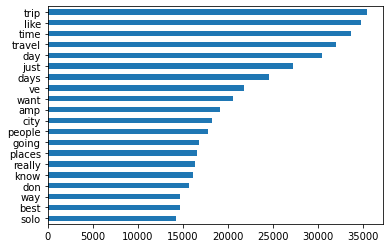

In [10]:
stops = list(ENGLISH_STOP_WORDS) + []

cv = CountVectorizer(min_df=10, stop_words=stops)
vect = cv.fit_transform(df['all_words'])

df_vect = pd.DataFrame(vect.todense(), columns=cv.get_feature_names())
df_vect.sum().sort_values().tail(20).plot.barh();

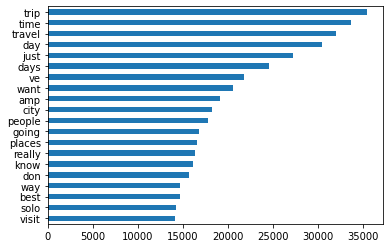

In [11]:
stops = list(ENGLISH_STOP_WORDS) + ['like']

cv = CountVectorizer(min_df=10, stop_words=stops)
vect = cv.fit_transform(df['all_words'])

df_vect = pd.DataFrame(vect.todense(), columns=cv.get_feature_names())
df_vect.sum().sort_values().tail(20).plot.barh();

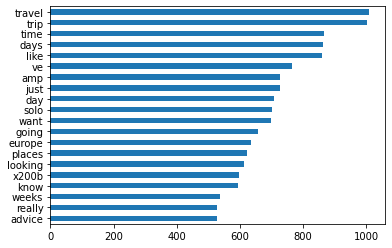

In [12]:
# TFIDF #
tf = TfidfVectorizer(min_df=10, stop_words=ENGLISH_STOP_WORDS)
tfvect = tf.fit_transform(df['all_words'])

df_tfvect = pd.DataFrame(tfvect.todense(), columns=tf.get_feature_names())
df_tfvect.sum().sort_values().tail(20).plot.barh();

tf_top_words = list(df_tfvect.sum().sort_values().tail(20).index)

### LDA Analysis adapted from Lecture with J

In [13]:
lda = LatentDirichletAllocation(random_state=42, n_components=5)
lda.fit(df_vect)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [14]:
df_lda = pd.DataFrame(lda.components_, columns=cv.get_feature_names()).T
df_lda

,0,1,2,3,4
00,0.249951,693.841686,82.007275,1.675002,53.226086
000,0.203769,131.422680,452.864281,412.385316,1177.123953
000aud,0.200009,0.200254,0.404892,9.994312,0.200532
000kip,0.270704,44.127094,0.200655,0.200661,0.200886
00am,0.200527,8.354680,22.030472,0.204849,0.209472
...,...,...,...,...,...
zurich,0.201273,0.200948,413.403007,0.339134,63.855637
zv2c3zdanzg31,0.201339,0.200000,0.200000,15.198393,0.200268
zürich,0.202126,0.206001,36.267793,0.202258,20.121822
škocjan,0.200942,0.200001,11.155045,0.200000,4.244011


In [15]:
df_lda[3].sort_values(ascending=False).head(10)

travel    16502.517322
just      10624.633511
ve        10320.936809
people     8735.967976
time       8465.666786
amp        7785.758735
want       6758.254858
know       6695.607990
visa       6472.998519
don        6448.179281
Name: 3, dtype: float64

In [16]:
texts = [df_vect.columns[df_vect.loc[index,:].to_numpy().nonzero()] for index in df_vect.index]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

ldamodel = models.ldamodel.LdaModel(corpus,                     # pass in our corpus
                                    id2word = dictionary,       # matches each word to its "number" or "spot" in the dictionary
                                    num_topics = 5,             # number of topics T to find
                                    passes = 10,                 # number of passes through corpus; similar to number of epochs
                                    minimum_probability = 0.01) # only include topics above this probability threshold



In [17]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=True)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.118421 -0.047773       1        1  33.449974
3      0.161934  0.004830       2        1  30.179115
1      0.094489 -0.185406       3        1  25.958807
2      0.030208  0.263952       4        1   5.962093
4     -0.405052 -0.035602       5        1   4.450016, topic_info=            Term          Freq         Total Category  logprob  loglift
1019      travel  29170.000000  29170.000000  Default  30.0000  30.0000
11268      https   3355.000000   3355.000000  Default  29.0000  29.0000
13191        amp   6602.000000   6602.000000  Default  28.0000  28.0000
1061         com   2802.000000   2802.000000  Default  27.0000  27.0000
242         trip  12533.000000  12533.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
508       africa    692.055969   1704.891602   Topic5  -5.3307   2.2107
442          san    548.267395    972.550781   Topic5  -5.5636   2.5391
1598       south    858.014954   4649.168945   Topic5  -5.1157   1.4224
543    countries    585.791016   5374.311035   Topic5  -5.4974   0.8958
1103          la    466.714203   1236.360840   Topic5  -5.7246   2.1381

[377 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
2394       1  0.209879      2019
2394       2  0.143681      2019
2394       3  0.206870      2019
2394       4  0.425024      2019
2394       5  0.015045      2019
...      ...       ...       ...
16710      4  0.994669   yerevan
721        3  0.002936    zambia
721        5  0.995327    zambia
724        3  0.002704  zimbabwe
724        5  0.997742  zimbabwe

[901 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3, 5])

## Exploratory Visualization: Word Clouds

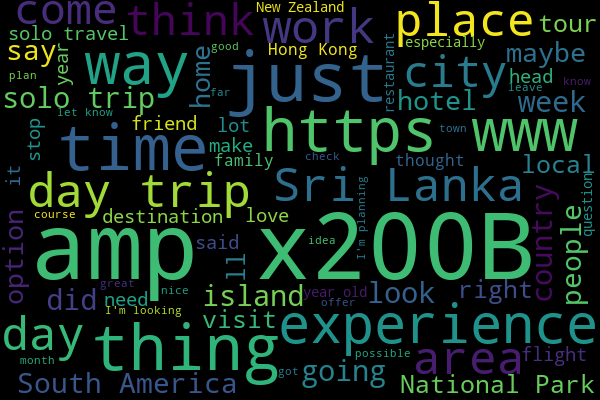

In [18]:
wc = wordcloud.WordCloud(width=600, height=400, max_words=75, stopwords=stops)
text = df['all_words'].str.cat()

wc.generate_from_text(text)
wc.to_image()

In [19]:
stops = list(ENGLISH_STOP_WORDS) + ['like']

def make_wordcloud(df, country, custom_stops = list(ENGLISH_STOP_WORDS) + ['like'], backcolor='white'):

    wc = wordcloud.WordCloud(width=600, height=400, max_words=75, stopwords=custom_stops, background_color=backcolor)
    text = df.loc[df['country'] == country, 'all_words'].str.cat()

    wc.generate_from_text(text)
    return wc.to_image()

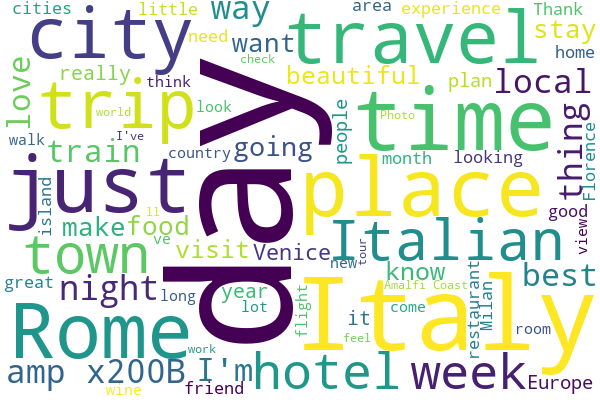

In [20]:
make_wordcloud(df, country='Italy')

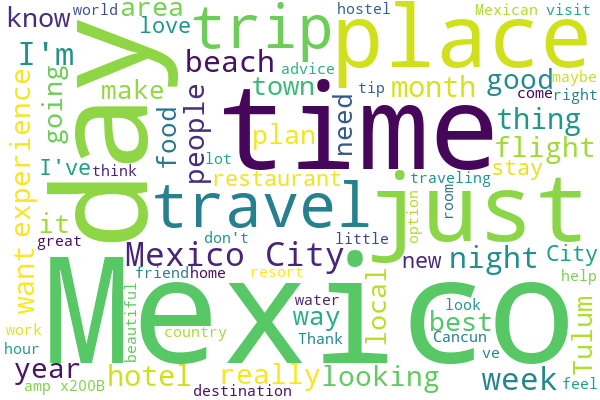

In [21]:
make_wordcloud(df, country='Mexico')

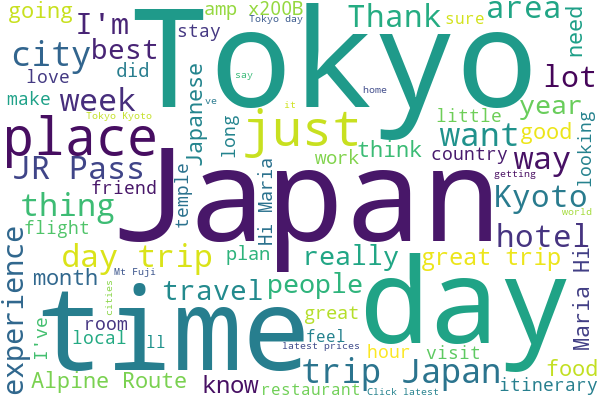

In [22]:
make_wordcloud(df, country='Japan')

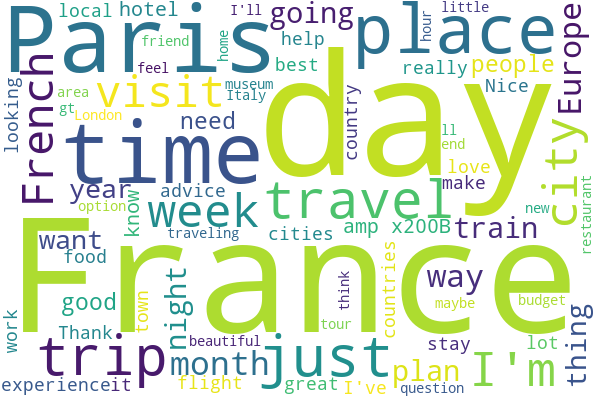

In [23]:
make_wordcloud(df, country='France')

## Words per Post

In [24]:
# Gets wordcount for the written text of the posts by country
def get_wordcount(df, country):
    return df.loc[df['country'] == country, 'text'].map(lambda x: len(x.split()))

In [25]:
popular_countries = [i for i in df_filed['country'].value_counts()[df_filed['country'].value_counts()>20].index]
popular_countries

['Italy',
 'Mexico',
 'Japan',
 'France',
 'India',
 'Spain',
 'Australia',
 'United States',
 'Argentina',
 'Portugal',
 'Switzerland',
 'Hong Kong',
 'Canada']

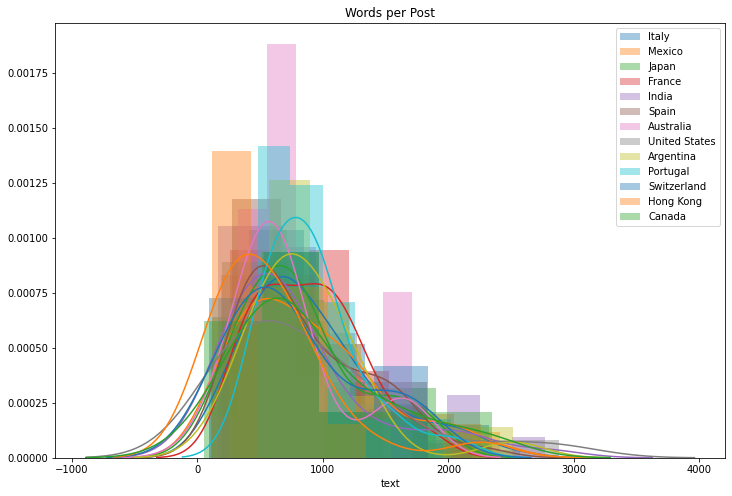

In [26]:
fig , ax = plt.subplots(figsize=(12,8))
for c in popular_countries:
        sns.distplot(get_wordcount(df=df_filed, country=c), label = c)

ax.legend()
ax.set_title('Words per Post');

In [27]:
df_vect

,00,000,000aud,000kip,00am,00pm,01,02,03,04,...,zones,zoo,zoom,zoos,zucchini,zurich,zv2c3zdanzg31,zürich,škocjan,спасибо
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34007,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34008,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34009,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34010,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


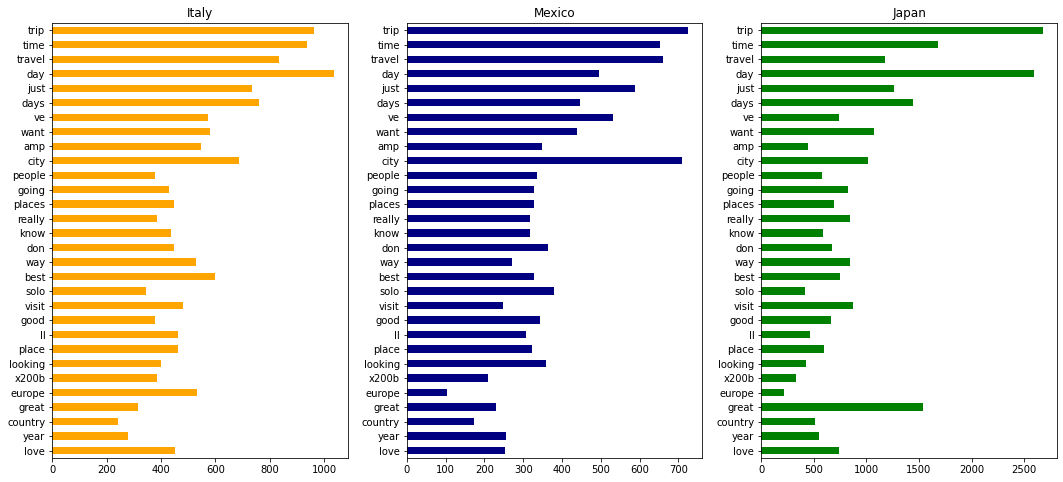

In [30]:
top_words = list(df_vect.sum().sort_values().tail(30).index)

df1 = df[df['country'] == popular_countries[0]]
df2 = df[df['country'] == popular_countries[1]]
df3 = df[df['country'] == popular_countries[2]]

vect_df1 = pd.DataFrame(cv.fit_transform(df1['all_words']).todense(),
                        columns= cv.get_feature_names())
vect_df2 = pd.DataFrame(cv.fit_transform(df2['all_words']).todense(),
                        columns= cv.get_feature_names())
vect_df3 = pd.DataFrame(cv.fit_transform(df3['all_words']).todense(),
                        columns= cv.get_feature_names())

fig , (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18,8))

vect_df1.loc[:, top_words].sum().plot.barh(ax=ax1, color='orange')
vect_df2.loc[:, top_words].sum().plot.barh(ax=ax2, color='navy')
vect_df3.loc[:, top_words].sum().plot.barh(ax=ax3, color='green')

ax1.set_title(f'{popular_countries[0]}')
ax2.set_title(f'{popular_countries[1]}')
ax3.set_title(f'{popular_countries[2]}');
plt.savefig('./images/word-frequency-comparison.png')